<a href="https://colab.research.google.com/github/ScienceMoo/DNA_structure_ML/blob/main/OnlyPositiveSamples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read data

In [ ]:
import scipy.io
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import matplotlib.pyplot as plt
%matplotlib inline

import math
import seaborn; seaborn.set() # Plot styling
from seaborn import heatmap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_folder = "/content/drive/MyDrive/Colab Notebooks"
file_name = "CTCF_sequences.mat"
file_path = file_folder + "/" + file_name

mat = scipy.io.loadmat(file_path, chars_as_strings=1, matlab_compatible=1)

sequences = mat['sequences']
sequences = [word[2:33] for word_array in sequences for word in word_array[0]]
sequences = np.array(sequences)
num_sample, seq_length = sequences.shape[0], sequences.shape[1]
# print("sequences.shape =", sequences.shape)
# print("num_sample =", num_sample)
# print("seq_length =", seq_length)

# print("sequences =", sequences[:5])

file_folder = "/content/drive/MyDrive/Colab Notebooks"
file_name = "CTCF_strengths.mat"
file_path = file_folder + "/" + file_name

mat = scipy.io.loadmat(file_path, chars_as_strings=1, matlab_compatible=1)

strengths = mat['TF_scores']
strengths = strengths
strengths = [thing[0] for thing in strengths]
y = np.array(strengths)


# Clean the data
inds = []
for idx, sequence in enumerate(sequences):
  if 'N' in sequence:
    inds.append(idx)

sequences = np.delete(sequences, inds, axis=0)
y = np.delete(y, inds, axis=0)

inds_outliers = np.where(y < 1.4)
sequences = np.delete(sequences, inds_outliers, axis=0)
y = np.delete(y, inds_outliers, axis=0)

inds_outliers = np.where(y >= 4)
sequences = np.delete(sequences, inds_outliers, axis=0)
y = np.delete(y, inds_outliers, axis=0)

print("sequences.shape =", sequences.shape)
num_sample, seq_length = sequences.shape[0], sequences.shape[1]
print("num_sample =", num_sample)
print("seq_length =", seq_length)

print("y.shape =", y.shape)

sequences.shape = (150572, 31)
num_sample = 150572
seq_length = 31
y.shape = (150572,)


# Prepare data

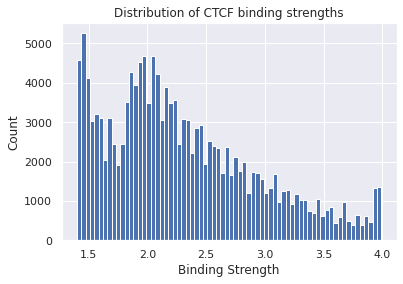

1.4
3.99


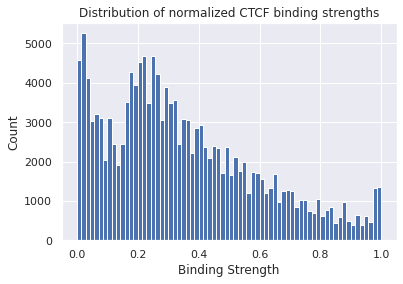

0.0
1.0


In [ ]:
# Normalize target values
plt.hist(y, 70)
plt.xlabel("Binding Strength")
plt.ylabel("Count")
plt.title("Distribution of CTCF binding strengths")
plt.show()
print(min(y))
print(max(y))
y = y - min(y)
y = y / max(y)
plt.hist(y, 70)
plt.xlabel("Binding Strength")
plt.ylabel("Count")
plt.title("Distribution of normalized CTCF binding strengths")
plt.show()
print(min(y))
print(max(y))

In [ ]:
# one-hot encoding
X = np.zeros(list(sequences.shape) + [4])

base_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

for row in range(num_sample):
    for col in range(seq_length):
        X[row,col,base_dict[sequences[row,col]]] = 1

print('Training set shape: {}'.format(X.shape))
print('Training set label shape: {}'.format(y.shape))
print('\nOne-hot encoding looks like:\n {}'.format(X[0,0:10,:]))

Training set shape: (150572, 31, 4)
Training set label shape: (150572,)

One-hot encoding looks like:
 [[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [ ]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.01)

# Deep Learning

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Dropout
from keras.activations import relu
from keras.layers.pooling import MaxPooling1D
from keras.optimizers import SGD
import keras

def clip_relu (x): 
    return keras.activations.relu(x, max_value=1.05, alpha=0.05)

# define the model
model = Sequential()
model.add(Conv1D(128, 25, padding='same', activation=clip_relu, input_shape=(seq_length, 4)))
# model.add(Conv1D(16, 8, padding='same', activation=clip_relu, input_shape=(seq_length, 4)))
#sanity check for dimensions
print('Shape of the output of first layer: {}'.format(model.predict_on_batch(X[0:32,:,:]).shape))
# model.add(MaxPooling1D(2))

# model.add(Dropout(0))
# model.add(Flatten())
model.add(Flatten())
model.add(Dense(1, activation=clip_relu))

sgd = SGD(lr=0.00005, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

hist = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=50)  # starts training
model.evaluate(X_test, y_test)

model.summary()

Shape of the output of first layer: (32, 31, 128)
Epoch 1/50
2386/2386 [==============================] - 23s 10ms/step - loss: 0.1868 - mean_absolute_error: 0.1868 - val_loss: 0.1547 - val_mean_absolute_error: 0.1547
Epoch 2/50
2386/2386 [==============================] - 22s 9ms/step - loss: 0.1431 - mean_absolute_error: 0.1431 - val_loss: 0.1319 - val_mean_absolute_error: 0.1319
Epoch 3/50
2386/2386 [==============================] - 22s 9ms/step - loss: 0.1231 - mean_absolute_error: 0.1231 - val_loss: 0.1141 - val_mean_absolute_error: 0.1141
Epoch 4/50
2386/2386 [==============================] - 22s 9ms/step - loss: 0.1068 - mean_absolute_error: 0.1068 - val_loss: 0.0997 - val_mean_absolute_error: 0.0997
Epoch 5/50
2386/2386 [==============================] - 22s 9ms/step - loss: 0.0948 - mean_absolute_error: 0.0948 - val_loss: 0.0897 - val_mean_absolute_error: 0.0897
Epoch 6/50
2386/2386 [==============================] - 22s 9ms/step - loss: 0.0867 - mean_absolute_error: 0.0867 

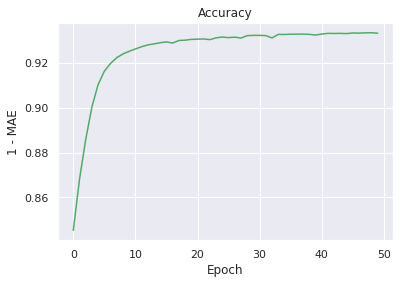

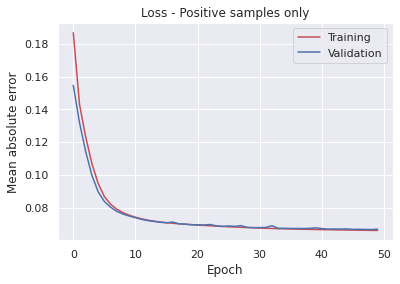

In [ ]:
arr = 1 - np.array(hist.history['val_mean_absolute_error'])

plt.plot(hist.epoch, arr, 'g')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("1 - MAE")
plt.show()

plt.plot(hist.epoch, hist.history['mean_absolute_error'], 'r', label="Training")
plt.plot(hist.epoch, hist.history['val_mean_absolute_error'], 'b', label="Validation")
plt.title("Loss - Positive samples only")
plt.xlabel("Epoch")
plt.ylabel("Mean absolute error")
plt.legend()
plt.show()

In [ ]:
#have a look at the filter
convlayer = model.layers[0]
weights = convlayer.get_weights()[0].squeeze()
weights = weights * 100
weights = weights.astype(int)
# weights = np.apply_along_axis(my_softmax, 1, weights)
print('Convolution parameter shape: {}'.format(weights.shape))
# print(weights)

Convolution parameter shape: (25, 4, 128)


Convolution parameter shape: (25, 4, 128)


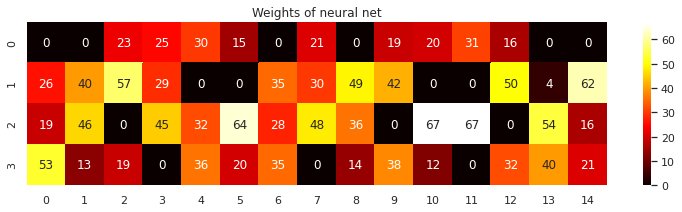

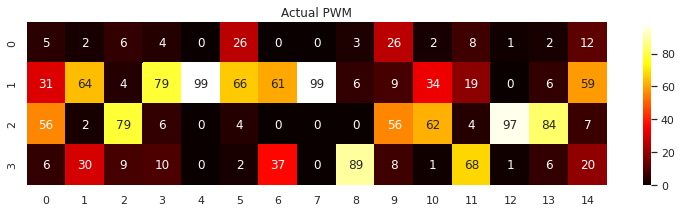

In [ ]:
def my_softmax(row):
  if min(row) != 0:
    row = row - min(row)
  return row / sum(row)

#have a look at the filter
convlayer = model.layers[0]
weights = convlayer.get_weights()[0].squeeze()
print('Convolution parameter shape: {}'.format(weights.shape))
# weights = np.apply_along_axis(my_softmax, 1, weights)
weights = np.mean(np.transpose(weights), 0)

weights = np.transpose(weights)
weights = np.apply_along_axis(my_softmax, 1, weights)

weights = weights * 100
weights = weights.astype(int)

fig=plt.figure(figsize=(13, 3))
heatmap(np.transpose(weights)[:, 5:-5],  annot=True, fmt="d", cmap="hot")
plt.title("Weights of neural net")
plt.show()


fig=plt.figure(figsize=(13, 3))
heatmap(np.transpose((actualPWM * 100).astype(int)), annot=True, fmt="d", cmap="hot")
plt.title("Actual PWM")
plt.show()

In [ ]:
# actual PWM
actualPWM = np.array([[0.0540, 0.3180, 0.5660, 0.0620],
    [0.0240, 0.6460, 0.0240, 0.3060],
    [0.0680, 0.0420, 0.7920, 0.0980],
    [0.0420, 0.7900, 0.0620, 0.1060],
    [     0, 0.9940,      0, 0.0060],
    [0.2620, 0.6660, 0.0460, 0.0260],
    [0.0040, 0.6180, 0.0020, 0.3760],
    [     0, 0.9980, 0.0020,      0],
    [0.0320, 0.0640, 0.0080, 0.8960],
    [0.2660, 0.0900, 0.5640, 0.0800],
    [0.0200, 0.3440, 0.6200, 0.0160],
    [0.0800, 0.1940, 0.0440, 0.6820],
    [0.0100, 0.0020, 0.9760, 0.0120],
    [0.0260, 0.0660, 0.8400, 0.0680],
    [0.1260, 0.5940, 0.0740, 0.2060]])


num2seq = ['A','C','G','T']
''.join([num2seq[np.argmax(actualPWM[i,:])] for i in range(actualPWM.shape[0])])  

'GCGCCCCCTGGTGGC'

In [ ]:
# predict highest strength sequence
num2seq = ['A','C','G','T']
''.join([num2seq[np.argmax(weights[i,:])] for i in range(5, weights.shape[0]-5)])  

'GTCCCCCCGCCTGTA'

In [ ]:
# predict lowest strength sequence
num2seq = ['A','C','G','T']
''.join([num2seq[np.argmin(weights[i,:])] for i in range(weights.shape[0])])

'AAGAAGTAGCTACAA'

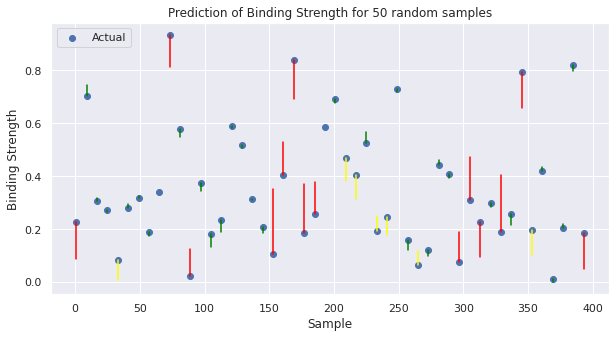

In [ ]:
# Test the model
pred = model.predict(X_test)
# pred = model.predict(X)

pred = pred.reshape((pred.shape[0],))

fig=plt.figure(figsize=(10, 5))

plt.scatter(np.arange(1,400, 8), y_test[0:399:8], label="Actual")
# plt.scatter(np.arange(1,400, 8), pred[0:399:8], label="Prediction")

colrs = []

for i in range(pred.shape[0]):
  if abs(pred[i]-y_test[i]) < 0.05:
    colrs.append('green')
  elif abs(pred[i]-y_test[i]) < 0.1:
    colrs.append('yellow')
  else:
    colrs.append('red')

for i in range(0, 399, 8):
  plt.plot([i+1, i+1], [pred[i], y_test[i]], c=colrs[i])
plt.xlabel('Sample')
plt.ylabel('Binding Strength')
plt.title('Prediction of Binding Strength for 50 random samples')
plt.legend(loc='upper left')
plt.show()

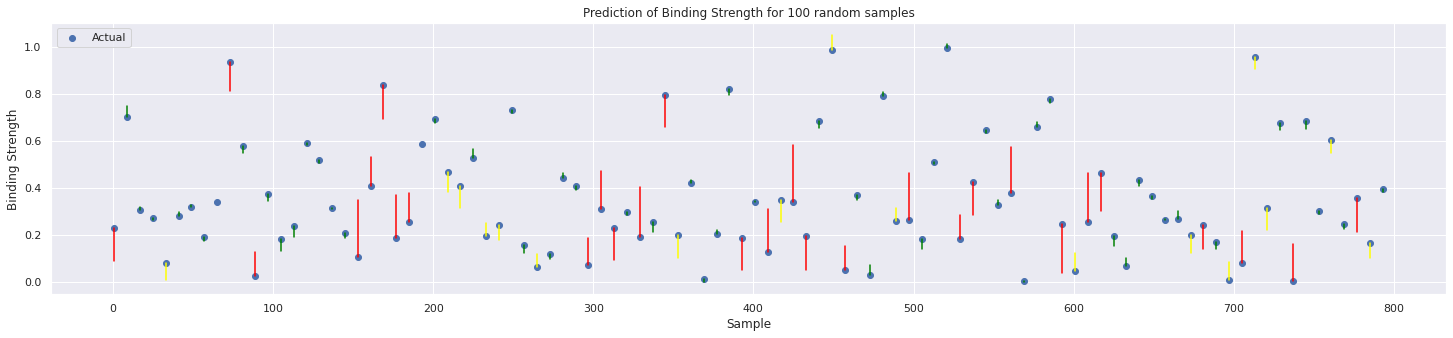

In [ ]:
pred = pred.reshape((pred.shape[0],))

fig=plt.figure(figsize=(25, 5))



# plt.scatter(np.arange(1,800, 8), pred[0:799:8], label="Prediction")

for i in range(0, 799, 8):
  plt.plot([i+1, i+1], [pred[i], y_test[i]], c=colrs[i])
  # plt.plot([i+1, i+1], [pred[i], y[i]], 'b')

plt.scatter(np.arange(1,800, 8), y_test[0:799:8], label="Actual")

plt.xlabel('Sample')
plt.ylabel('Binding Strength')
plt.title('Prediction of Binding Strength for 100 random samples')
plt.legend(loc='upper left')
plt.show()

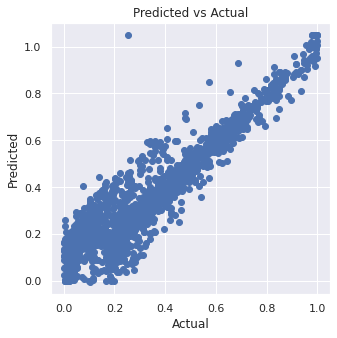

In [ ]:
fig=plt.figure(figsize=(5, 5))
plt.scatter(y_test, pred)
# plt.scatter(y, pred)
# Plot
plt.title('Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

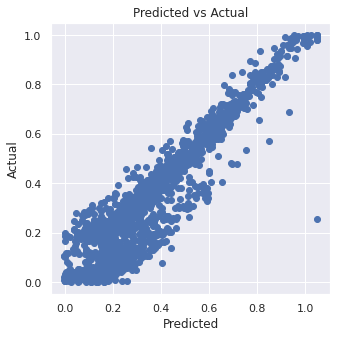

In [ ]:
fig=plt.figure(figsize=(5, 5))
plt.scatter(pred, y_test)
# plt.scatter(pred, y)
# Plot
plt.title('Predicted vs Actual')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# true_positives = 0
# false_positives = 0
# true_negatives = 0
# false_negatives = 0

# for i in range(pred.shape[0]):
#   if pred[i] > 1.1 and y_test[i] > 0:
#     true_positives += 1
#   elif pred[i] <= 1.1 and y_test[i] > 0:
#     false_negatives += 1
#   elif pred[i] > 1.1 and y_test[i] == 0:
#     false_positives += 1
#   elif pred[i] <= 1.1 and y_test[i] == 0:
#     true_negatives += 1

# confusion = [[true_negatives, false_positives], [false_negatives, true_positives]]
# confusion = np.array(confusion)
# confusion = - confusion
# np.fill_diagonal(confusion, - confusion.diagonal())
# heatmap(confusion, annot=True, fmt="d", cmap="Purples")
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()


# total_positive = (true_positives + false_negatives)
# total_negative = (true_negatives + false_positives)

# true_positives = true_positives / total_positive
# false_positives = false_positives / total_positive
# true_negatives = true_negatives / total_negative
# false_negatives = false_negatives / total_negative

# # for i in range(pred.shape[0]):
# #   if pred[i] == 0 and y[i] == 0:
# #     true_negatives += 1
# #   elif pred[i] > 0 and y[i] > 0:
# #     true_positives += 1
# #   elif pred[i] == 0 and y[i] > 0:
# #     false_negatives += 1
# #   elif pred[i] > 0.5 and y[i] == 0:
# #     false_positives += 1

# confusion = [[true_negatives, false_positives], [false_negatives, true_positives]]
# confusion = np.array(confusion)
# confusion = - confusion
# np.fill_diagonal(confusion, - confusion.diagonal())
# heatmap(confusion, annot=True, fmt=".4f", cmap="Purples")
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()